# Implémentez un modèle de scoring

## Imports

In [1]:
import pandas as pd
import numpy as np

from numpy import argmax

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot

from sklearn.preprocessing import LabelEncoder, LabelBinarizer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RepeatedStratifiedKFold
import xgboost as xgb
import lightgbm as lgm
import re

from sklearn import metrics
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, classification_report

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

import datetime
from datetime import datetime
import os
import tempfile
import time

import mlflow
from mlflow.models import infer_signature

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import shap

import random

import dill as pickle

## Nettoyage des données

In [5]:
mlflow.set_tracking_uri("http://localhost:8080")

In [6]:
df_train = pd.read_csv('files/application_train.csv')
df_test = pd.read_csv('files/application_test.csv')
print('Training data shape: ', df_train.shape)
df_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# Columns
#cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(df_app_train, car_th=10)

# ERRORS
df_app_train = df_train[~(df_train.CODE_GENDER.str.contains("XNA"))]  
df_app_train = df_train[df_train.NAME_FAMILY_STATUS != "Unknown"]  

df_app_test = df_test[~(df_test.CODE_GENDER.str.contains("XNA"))]  
df_app_test = df_test[df_test.NAME_FAMILY_STATUS != "Unknown"]  

# DROP
cols = ["NAME_HOUSING_TYPE", "WEEKDAY_APPR_PROCESS_START", "FONDKAPREMONT_MODE", "WALLSMATERIAL_MODE", "HOUSETYPE_MODE",
        "EMERGENCYSTATE_MODE","FLAG_MOBIL", "FLAG_EMP_PHONE","FLAG_WORK_PHONE", "FLAG_CONT_MOBILE", "FLAG_PHONE", "FLAG_EMAIL"]
df_app_train.drop(cols, axis = 1, inplace = True)
df_app_test.drop(cols, axis = 1, inplace = True)

# REGION
cols = ["REG_REGION_NOT_LIVE_REGION","REG_REGION_NOT_WORK_REGION", "LIVE_REGION_NOT_WORK_REGION", "REG_CITY_NOT_LIVE_CITY",
 "REG_CITY_NOT_WORK_CITY","LIVE_CITY_NOT_WORK_CITY"]
df_app_train["REGION"] = df_app_train[cols].sum(axis = 1)
df_app_train.drop(cols, axis = 1, inplace = True)
df_app_test["REGION"] = df_app_test[cols].sum(axis = 1)
df_app_test.drop(cols, axis = 1, inplace = True)

# Drop FLAG_DOCUMENT 
df_app_train.drop(df_app_train.columns[df_app_train.columns.str.contains("FLAG_DOCUMENT")], axis = 1, inplace = True)
df_app_test.drop(df_app_test.columns[df_app_test.columns.str.contains("FLAG_DOCUMENT")], axis = 1, inplace = True)

In [8]:
def rare_encoder(data, col, rare_perc):
    temp = data[col].value_counts() / len(data) < rare_perc
    data[col] = np.where(~data[col].isin(temp[temp < rare_perc].index), "Rare", data[col])

In [9]:
# RARE ENCODER
df_app_train["NAME_EDUCATION_TYPE"] = np.where(df_app_train.NAME_EDUCATION_TYPE == "Academic degree", "Higher education", df_app_train.NAME_EDUCATION_TYPE)
df_app_test["NAME_EDUCATION_TYPE"] = np.where(df_app_test.NAME_EDUCATION_TYPE == "Academic degree", "Higher education", df_app_test.NAME_EDUCATION_TYPE)


df_app_train["ORGANIZATION_TYPE"] = np.where(df_app_train.ORGANIZATION_TYPE.str.contains("Business Entity"), "Business Entity", df_app_train.ORGANIZATION_TYPE)
df_app_train["ORGANIZATION_TYPE"] = np.where(df_app_train.ORGANIZATION_TYPE.str.contains("Industry"), "Industry", df_app_train.ORGANIZATION_TYPE)
df_app_train["ORGANIZATION_TYPE"] = np.where(df_app_train.ORGANIZATION_TYPE.str.contains("Trade"), "Trade", df_app_train.ORGANIZATION_TYPE)
df_app_train["ORGANIZATION_TYPE"] = np.where(df_app_train.ORGANIZATION_TYPE.str.contains("Transport"), "Transport", df_app_train.ORGANIZATION_TYPE)
df_app_train["ORGANIZATION_TYPE"] = np.where(df_app_train.ORGANIZATION_TYPE.isin(["School", "Kindergarten", "University"]), "Education", df_app_train.ORGANIZATION_TYPE)
df_app_train["ORGANIZATION_TYPE"] = np.where(df_app_train.ORGANIZATION_TYPE.isin(["Emergency","Police", "Medicine","Goverment", "Postal", "Military", "Security Ministries", "Legal Services"]), "Public", df_app_train.ORGANIZATION_TYPE)
df_app_train["ORGANIZATION_TYPE"] = np.where(df_app_train.ORGANIZATION_TYPE.isin(["Bank", "Insurance"]), "Finance", df_app_train.ORGANIZATION_TYPE)
df_app_train["ORGANIZATION_TYPE"] = np.where(df_app_train.ORGANIZATION_TYPE.isin(["Realtor", "Housing"]), "House", df_app_train.ORGANIZATION_TYPE)
df_app_train["ORGANIZATION_TYPE"] = np.where(df_app_train.ORGANIZATION_TYPE.isin(["Hotel", "Restaurant"]), "HotelRestaurant", df_app_train.ORGANIZATION_TYPE)
df_app_train["ORGANIZATION_TYPE"] = np.where(df_app_train.ORGANIZATION_TYPE.isin(["Cleaning","Electricity", "Telecom", "Mobile", "Advertising", "Religion", "Culture"]), "Other", df_app_train.ORGANIZATION_TYPE)

df_app_train["OCCUPATION_TYPE"] = np.where(df_app_train.OCCUPATION_TYPE.isin(["Low-skill Laborers", "Cooking staff", "Security staff", "Private service staff", "Cleaning staff", "Waiters/barmen staff"]), "Low-skill Laborers", df_app_train.OCCUPATION_TYPE)
df_app_train["OCCUPATION_TYPE"] = np.where(df_app_train.OCCUPATION_TYPE.isin(["IT staff", "High skill tech staff"]), "High skill tech staff", df_app_train.OCCUPATION_TYPE)

df_app_test["ORGANIZATION_TYPE"] = np.where(df_app_test.ORGANIZATION_TYPE.str.contains("Business Entity"), "Business Entity", df_app_test.ORGANIZATION_TYPE)
df_app_test["ORGANIZATION_TYPE"] = np.where(df_app_test.ORGANIZATION_TYPE.str.contains("Industry"), "Industry", df_app_test.ORGANIZATION_TYPE)
df_app_test["ORGANIZATION_TYPE"] = np.where(df_app_test.ORGANIZATION_TYPE.str.contains("Trade"), "Trade", df_app_test.ORGANIZATION_TYPE)
df_app_test["ORGANIZATION_TYPE"] = np.where(df_app_test.ORGANIZATION_TYPE.str.contains("Transport"), "Transport", df_app_test.ORGANIZATION_TYPE)
df_app_test["ORGANIZATION_TYPE"] = np.where(df_app_test.ORGANIZATION_TYPE.isin(["School", "Kindergarten", "University"]), "Education", df_app_test.ORGANIZATION_TYPE)
df_app_test["ORGANIZATION_TYPE"] = np.where(df_app_test.ORGANIZATION_TYPE.isin(["Emergency","Police", "Medicine","Goverment", "Postal", "Military", "Security Ministries", "Legal Services"]), "Public", df_app_test.ORGANIZATION_TYPE)
df_app_test["ORGANIZATION_TYPE"] = np.where(df_app_test.ORGANIZATION_TYPE.isin(["Bank", "Insurance"]), "Finance", df_app_test.ORGANIZATION_TYPE)
df_app_test["ORGANIZATION_TYPE"] = np.where(df_app_test.ORGANIZATION_TYPE.isin(["Realtor", "Housing"]), "House", df_app_test.ORGANIZATION_TYPE)
df_app_test["ORGANIZATION_TYPE"] = np.where(df_app_test.ORGANIZATION_TYPE.isin(["Hotel", "Restaurant"]), "HotelRestaurant", df_app_test.ORGANIZATION_TYPE)
df_app_test["ORGANIZATION_TYPE"] = np.where(df_app_test.ORGANIZATION_TYPE.isin(["Cleaning","Electricity", "Telecom", "Mobile", "Advertising", "Religion", "Culture"]), "Other", df_app_test.ORGANIZATION_TYPE)

df_app_test["OCCUPATION_TYPE"] = np.where(df_app_test.OCCUPATION_TYPE.isin(["Low-skill Laborers", "Cooking staff", "Security staff", "Private service staff", "Cleaning staff", "Waiters/barmen staff"]), "Low-skill Laborers", df_app_test.OCCUPATION_TYPE)
df_app_test["OCCUPATION_TYPE"] = np.where(df_app_test.OCCUPATION_TYPE.isin(["IT staff", "High skill tech staff"]), "High skill tech staff", df_app_test.OCCUPATION_TYPE)

rare_cols = ["NAME_TYPE_SUITE", "NAME_INCOME_TYPE"]

for i in rare_cols:
    rare_encoder(df_app_train, i, rare_perc = 0.01)
    rare_encoder(df_app_test, i, rare_perc = 0.01)

    
# Categorical features with Binary encode (0 or 1; two categories)
for bin_feature in ["NAME_CONTRACT_TYPE", 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    df_app_train[bin_feature], uniques = pd.factorize(df_app_train[bin_feature])
    df_app_test[bin_feature], uniques = pd.factorize(df_app_test[bin_feature])
    
    
# Categorical features with One-Hot encode
#df_app_train, cat_cols = one_hot_encoder(df_app_train, nan_as_category=False)


# NaN values for DAYS_EMPLOYED: 365.243 -> nan
df_app_train['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
df_app_test["DAYS_EMPLOYED"].replace(365243, np.nan, inplace = True)

# EXT SOURCE MEAN FROM OTHER ASSOCIATIONS 
df_app_train["EXT_SOURCE_MEAN"] = df_app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
df_app_test["EXT_SOURCE_MEAN"] = df_app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)

#Drop Columns 'EXT_SOURCE_1', 'EXT_SOURCE_2','EXT_SOURCE_3
df_app_train.drop(['EXT_SOURCE_1', 'EXT_SOURCE_2','EXT_SOURCE_3'], axis=1, inplace=True)
df_app_test.drop(['EXT_SOURCE_1', 'EXT_SOURCE_2','EXT_SOURCE_3'], axis=1, inplace=True)

print("APPLICATION TRAIN/TEST SHAPE:", df_app_train.shape, "\n")
print("APPLICATION TRAIN/TEST SHAPE:", df_app_test.shape, "\n")
df_app_train.head()

APPLICATION TRAIN/TEST SHAPE: (307509, 83) 

APPLICATION TRAIN/TEST SHAPE: (48744, 82) 



,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,REGION,EXT_SOURCE_MEAN
0,100002,1,0,0,0,0,0,202500.0,406597.5,24700.5,...,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.161787
1,100003,0,0,1,0,1,0,270000.0,1293502.5,35698.5,...,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.466757
2,100004,0,1,0,1,0,0,67500.0,135000.0,6750.0,...,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.642739
3,100006,0,0,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,-617.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0.650442
4,100007,0,0,0,0,0,0,121500.0,513000.0,21865.5,...,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.322738


In [10]:
df_train = df_app_train
df_test = df_app_test

## Feature engineering

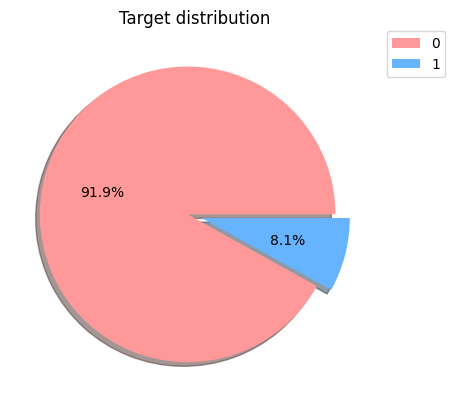

In [11]:
colors = ['#ff9999','#66b3ff']
data = df_train['TARGET'].value_counts()
ax = data.plot(kind="pie", autopct='%1.1f%%', shadow=True, explode=[0.05, 0.05], colors=colors, legend=True, title='Target distribution', ylabel='', labeldistance=None)
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

On voit bien qu'il y a un deséquilibre de la répartition de nos données par rapport à la target, il serait intéressant de mettre en place une technique pour ré-équilibrer ces données.

In [12]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in df_train:
    if df_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(df_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(df_train[col])
            # Transform both training and testing data
            df_train[col] = le.transform(df_train[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

0 columns were label encoded.


In [13]:
# one-hot encoding of categorical variables
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

print('Training Features shape: ', df_train.shape)
print('Testing Features shape: ', df_test.shape)

Training Features shape:  (307509, 125)
Testing Features shape:  (48744, 123)


In [14]:
df_train_domain = df_train.copy()
df_test_domain = df_test.copy()

df_train_domain['CREDIT_INCOME_PERCENT'] = df_train_domain['AMT_CREDIT'] / df_train_domain['AMT_INCOME_TOTAL']
df_train_domain['ANNUITY_INCOME_PERCENT'] = df_train_domain['AMT_ANNUITY'] / df_train_domain['AMT_INCOME_TOTAL']
df_train_domain['CREDIT_TERM'] = df_train_domain['AMT_ANNUITY'] / df_train_domain['AMT_CREDIT']
df_train_domain['DAYS_EMPLOYED_PERCENT'] = df_train_domain['DAYS_EMPLOYED'] / df_train_domain['DAYS_BIRTH']


df_test_domain['CREDIT_INCOME_PERCENT'] = df_test_domain['AMT_CREDIT'] / df_test_domain['AMT_INCOME_TOTAL']
df_test_domain['ANNUITY_INCOME_PERCENT'] = df_test_domain['AMT_ANNUITY'] / df_test_domain['AMT_INCOME_TOTAL']
df_test_domain['CREDIT_TERM'] = df_test_domain['AMT_ANNUITY'] / df_test_domain['AMT_CREDIT']
df_test_domain['DAYS_EMPLOYED_PERCENT'] = df_test_domain['DAYS_EMPLOYED'] / df_test_domain['DAYS_BIRTH']

In [15]:
df_train_domain['TARGET'] = df_train['TARGET']

In [16]:
def missing_values(data, plot=False):
    mst = pd.DataFrame(
        {"Num_Missing": data.isnull().sum(), "Missing_Ratio": data.isnull().sum() / data.shape[0]}).sort_values(
        "Num_Missing", ascending=False)
    mst["DataTypes"] = data[mst.index].dtypes.values
    mst = mst[mst.Num_Missing > 0].reset_index().rename({"index": "Feature"}, axis=1)

    print("Number of Variables include Missing Values:", mst.shape[0], "\n")

    if mst[mst.Missing_Ratio >= 0.3].shape[0] > 0:
        print("Full Missing Variables:", mst[mst.Missing_Ratio >= 1.0].Feature.tolist())
        data.drop(mst[mst.Missing_Ratio >= 1.0].Feature.tolist(), axis=1, inplace=True)

        print("Full missing variables are deleted!", "\n")

    if plot:
        plt.figure(figsize=(25, 8))
        p = sns.barplot(mst.Feature, mst.Missing_Ratio)
        for rotate in p.get_xticklabels():
            rotate.set_rotation(90)
        plt.show()

    print(mst, "\n")

In [17]:
missing_values(df_train_domain)

Number of Variables include Missing Values: 62 

Full Missing Variables: []
Full missing variables are deleted! 

                     Feature  Num_Missing  Missing_Ratio DataTypes
0            COMMONAREA_MODE       214864       0.698724   float64
1            COMMONAREA_MEDI       214864       0.698724   float64
2             COMMONAREA_AVG       214864       0.698724   float64
3   NONLIVINGAPARTMENTS_MODE       213513       0.694331   float64
4    NONLIVINGAPARTMENTS_AVG       213513       0.694331   float64
..                       ...          ...            ...       ...
57           EXT_SOURCE_MEAN          172       0.000559   float64
58               CREDIT_TERM           12       0.000039   float64
59    ANNUITY_INCOME_PERCENT           12       0.000039   float64
60               AMT_ANNUITY           12       0.000039   float64
61    DAYS_LAST_PHONE_CHANGE            1       0.000003   float64

[62 rows x 4 columns] 



In [18]:
missing_values(df_test_domain)

Number of Variables include Missing Values: 60 

Full Missing Variables: []
Full missing variables are deleted! 

                         Feature  Num_Missing  Missing_Ratio DataTypes
0                COMMONAREA_MEDI        33495       0.687161   float64
1                 COMMONAREA_AVG        33495       0.687161   float64
2                COMMONAREA_MODE        33495       0.687161   float64
3       NONLIVINGAPARTMENTS_MEDI        33347       0.684125   float64
4        NONLIVINGAPARTMENTS_AVG        33347       0.684125   float64
5       NONLIVINGAPARTMENTS_MODE        33347       0.684125   float64
6           LIVINGAPARTMENTS_AVG        32780       0.672493   float64
7          LIVINGAPARTMENTS_MODE        32780       0.672493   float64
8          LIVINGAPARTMENTS_MEDI        32780       0.672493   float64
9                 FLOORSMIN_MEDI        32466       0.666051   float64
10                 FLOORSMIN_AVG        32466       0.666051   float64
11                FLOORSMIN_MODE  

In [19]:
count = np.isinf(df_train_domain).values.sum()
count

0

In [20]:
count = np.isinf(df_test_domain).values.sum()
count

0

In [21]:
print('Missing value Train: %d' % sum(df_train_domain.isna().sum()))
print('Missing value Test: %d' % sum(df_test_domain.isna().sum()))

Missing value Train: 8263977
Missing value Test: 1274780


In [22]:
# Initialiser SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Affecter les colonnes avec les valeurs manquantes
col_nan = df_train_domain.columns[df_train_domain.isnull().any()].values

# X = imputer.fit_transform(df_train1)
df_train_domain[col_nan] = imputer.fit_transform(df_train_domain[col_nan])
display(df_train_domain.head())

# Affecter les colonnes avec les valeurs manquantes
col_nan = df_test_domain.columns[df_test_domain.isnull().any()].values

# X = imputer.fit_transform(df_train1)
df_test_domain[col_nan] = imputer.fit_transform(df_test_domain[col_nan])
df_test_domain.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Trade,ORGANIZATION_TYPE_Transport,ORGANIZATION_TYPE_XNA,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
0,100002,1,0,0,0,0,0,202500.0,406597.5,24700.5,...,False,False,False,False,False,False,2.007889,0.121978,0.060749,0.067329
1,100003,0,0,1,0,1,0,270000.0,1293502.5,35698.5,...,False,False,False,False,False,False,4.790750,0.132217,0.027598,0.070862
2,100004,0,1,0,1,0,0,67500.0,135000.0,6750.0,...,False,False,False,False,False,False,2.000000,0.100000,0.050000,0.011814
3,100006,0,0,1,0,0,0,135000.0,312682.5,29686.5,...,False,False,False,False,False,False,2.316167,0.219900,0.094941,0.159905
4,100007,0,0,0,0,0,0,121500.0,513000.0,21865.5,...,False,False,False,False,False,False,4.222222,0.179963,0.042623,0.152418


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Trade,ORGANIZATION_TYPE_Transport,ORGANIZATION_TYPE_XNA,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
0,100001,0,0,0,0,0,135000.0,568800.0,20560.5,450000.0,...,False,False,False,False,False,False,4.213333,0.152300,0.036147,0.121044
1,100005,0,1,0,0,0,99000.0,222768.0,17370.0,180000.0,...,False,True,False,False,False,False,2.250182,0.175455,0.077973,0.247398
2,100013,0,1,1,0,0,202500.0,663264.0,69777.0,630000.0,...,False,False,False,False,True,False,3.275378,0.344578,0.105202,0.222477
3,100028,0,0,0,0,2,315000.0,1575000.0,49018.5,1575000.0,...,False,False,False,False,False,False,5.000000,0.155614,0.031123,0.133515
4,100038,0,1,1,1,1,180000.0,625500.0,32067.0,625500.0,...,False,False,False,False,False,False,3.475000,0.178150,0.051266,0.168021


In [23]:
print('Missing value Trainning: %d' % sum(df_train_domain.isna().sum()))
print('Missing value Testing: %d' % sum(df_test_domain.isna().sum()))

Missing value Trainning: 0
Missing value Testing: 0


In [24]:
X = df_train_domain.drop(['TARGET','SK_ID_CURR'], axis=1)

In [25]:
X

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Trade,ORGANIZATION_TYPE_Transport,ORGANIZATION_TYPE_XNA,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
0,0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,False,False,False,False,False,False,2.007889,0.121978,0.060749,0.067329
1,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,False,False,False,False,False,False,4.790750,0.132217,0.027598,0.070862
2,1,0,1,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,False,False,False,False,False,False,2.000000,0.100000,0.050000,0.011814
3,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,False,False,False,False,False,False,2.316167,0.219900,0.094941,0.159905
4,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,False,False,False,False,False,False,4.222222,0.179963,0.042623,0.152418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,0,0,1,0,157500.0,254700.0,27558.0,225000.0,0.032561,...,False,False,True,False,False,False,1.617143,0.174971,0.108198,0.025303
307507,0,1,0,0,0,72000.0,269550.0,12001.5,225000.0,0.025164,...,False,False,False,False,False,True,3.743750,0.166687,0.044524,0.156862
307508,0,1,0,0,0,153000.0,677664.0,29979.0,585000.0,0.005002,...,False,False,False,False,False,False,4.429176,0.195941,0.044239,0.529266
307509,0,1,0,0,0,171000.0,370107.0,20205.0,319500.0,0.005313,...,False,False,False,False,False,False,2.164368,0.118158,0.054592,0.400134


In [26]:
y = df_train_domain['TARGET']

In [27]:
y

0         1
1         0
2         0
3         0
4         0
         ..
307506    0
307507    0
307508    0
307509    1
307510    0
Name: TARGET, Length: 307509, dtype: int64

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42,stratify=y)

In [26]:
temp = []
for element in X_test.columns.tolist():
    if element not in df_test_domain.columns.tolist():
        temp.append(element)
 
print(temp)

['NAME_TYPE_SUITE_Children']


In [27]:
df_test_domain[temp] = 0

In [28]:
df_test_domain = df_test_domain.drop(['SK_ID_CURR'], axis=1)

In [29]:
df_test_domain

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Trade,ORGANIZATION_TYPE_Transport,ORGANIZATION_TYPE_XNA,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,NAME_TYPE_SUITE_Children
0,0,0,0,0,0,135000.0,568800.0,20560.5,450000.0,0.018850,...,False,False,False,False,False,4.213333,0.152300,0.036147,0.121044,0
1,0,1,0,0,0,99000.0,222768.0,17370.0,180000.0,0.035792,...,True,False,False,False,False,2.250182,0.175455,0.077973,0.247398,0
2,0,1,1,0,0,202500.0,663264.0,69777.0,630000.0,0.019101,...,False,False,False,True,False,3.275378,0.344578,0.105202,0.222477,0
3,0,0,0,0,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,...,False,False,False,False,False,5.000000,0.155614,0.031123,0.133515,0
4,0,1,1,1,1,180000.0,625500.0,32067.0,625500.0,0.010032,...,False,False,False,False,False,3.475000,0.178150,0.051266,0.168021,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,0,0,0,0,0,121500.0,412560.0,17473.5,270000.0,0.002042,...,False,False,False,False,False,3.395556,0.143815,0.042354,0.258838,0
48740,0,0,0,1,2,157500.0,622413.0,31909.5,495000.0,0.035792,...,False,False,True,False,False,3.951829,0.202600,0.051267,0.102718,0
48741,0,0,1,0,1,202500.0,315000.0,33205.5,315000.0,0.026392,...,False,False,False,False,False,1.555556,0.163978,0.105414,0.190742,0
48742,0,1,0,1,0,225000.0,450000.0,25128.0,450000.0,0.018850,...,True,False,False,False,False,2.000000,0.111680,0.055840,0.195518,0


In [30]:
df_test_domain.to_csv('test.csv', index=False)

In [31]:
df_train_domain.to_csv('train.csv', index=False)

In [32]:
df_train_domain

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Trade,ORGANIZATION_TYPE_Transport,ORGANIZATION_TYPE_XNA,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
0,100002,1,0,0,0,0,0,202500.0,406597.5,24700.5,...,False,False,False,False,False,False,2.007889,0.121978,0.060749,0.067329
1,100003,0,0,1,0,1,0,270000.0,1293502.5,35698.5,...,False,False,False,False,False,False,4.790750,0.132217,0.027598,0.070862
2,100004,0,1,0,1,0,0,67500.0,135000.0,6750.0,...,False,False,False,False,False,False,2.000000,0.100000,0.050000,0.011814
3,100006,0,0,1,0,0,0,135000.0,312682.5,29686.5,...,False,False,False,False,False,False,2.316167,0.219900,0.094941,0.159905
4,100007,0,0,0,0,0,0,121500.0,513000.0,21865.5,...,False,False,False,False,False,False,4.222222,0.179963,0.042623,0.152418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,0,0,1,0,157500.0,254700.0,27558.0,...,False,False,True,False,False,False,1.617143,0.174971,0.108198,0.025303
307507,456252,0,0,1,0,0,0,72000.0,269550.0,12001.5,...,False,False,False,False,False,True,3.743750,0.166687,0.044524,0.156862
307508,456253,0,0,1,0,0,0,153000.0,677664.0,29979.0,...,False,False,False,False,False,False,4.429176,0.195941,0.044239,0.529266
307509,456254,1,0,1,0,0,0,171000.0,370107.0,20205.0,...,False,False,False,False,False,False,2.164368,0.118158,0.054592,0.400134


In [29]:
print('Train class distribution')
print(y_train.value_counts(normalize=True))

print('Test class distribution')
print(y_test.value_counts(normalize=True))

Train class distribution
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64
Test class distribution
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64


# Modélisation

## Première modélisation simple

In [30]:
#Train simple Random Forest classifier
with mlflow.start_run() as run:
    start = time.time()
    params = {"n_estimators":2, "random_state":42, "n_jobs":-1}
    clf = RandomForestClassifier(**params)
    clf.fit(X_train.values, y_train.values)
    y_pred = clf.predict(X_test.values)
    y_probas = clf.predict_proba(X_test.values)[::,1]
    signature = infer_signature(X_test.values, y_pred)
    tps = time.time() - start

    mlflow.log_params(params)
    mlflow.log_metrics({"roc_auc": roc_auc_score(y_test.values, y_probas),
                        "accuracy": accuracy_score(y_test.values, y_pred),
                        "precision": average_precision_score(y_test.values, y_probas),
                        "f1": f1_score(y_test.values, y_pred),
                        "recall": recall_score(y_test.values, y_pred)})

    print(classification_report(y_test,y_pred))
    print("roc_auc: ", roc_auc_score(y_test.values, y_probas))
    print("time: ", tps)

    run_id = run.info.run_id
    mlflow.register_model("runs:/"+run_id+"/sklearn-model", "sk-learn-random-forest-classifier")
mlflow.end_run()


2024/07/08 13:36:55 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

Successfully registered model 'sk-learn-random-forest-classifier'.
2024/07/08 13:37:00 INFO mlflow.store

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     56537
           1       0.16      0.03      0.04      4965

    accuracy                           0.91     61502
   macro avg       0.54      0.51      0.50     61502
weighted avg       0.86      0.91      0.88     61502

roc_auc:  0.5498720005138469
time:  3.2659761905670166


Created version '1' of model 'sk-learn-random-forest-classifier'.


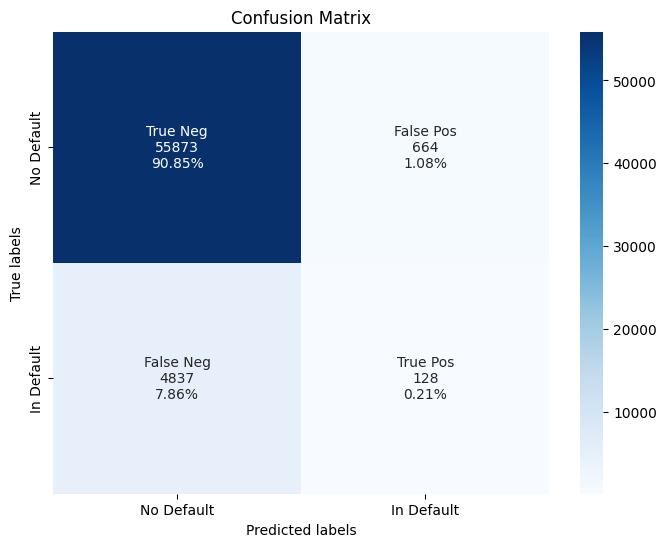

In [31]:
#Display confusion matrix
y_probas = clf.predict_proba(X_test.values)
cm = confusion_matrix(y_test, np.argmax(y_probas,axis = 1))

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['No Default', 'In Default'])
ax.yaxis.set_ticklabels(['No Default', 'In Default'])

plt.show()

In [32]:
def annot_auc(x,y, ax=None):
    plt.annotate("{:.3f}".format(y), xy=(x, y), xytext=(x*2, y/2), fontsize=12,
                     bbox=dict(facecolor='white', fc ="0.99", edgecolor='black', boxstyle='round'),
                     arrowprops=dict(arrowstyle = "->",connectionstyle = "angle,angleA=90,angleB=180,rad=0",color='black')
                     )

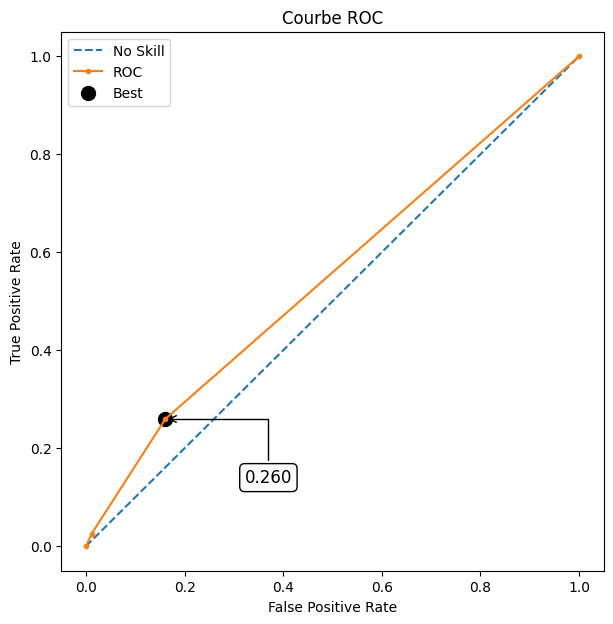

In [33]:
#Display ROC curve
plt.figure(figsize=(7,7))

fpr, tpr, threshold = roc_curve(y_test, y_probas[::,1])

J = tpr - fpr
ix = argmax(J)

# graphique roc curve du modèle
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='ROC')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best',s=100)
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

plt.title('Courbe ROC')

annot_auc(fpr[ix],tpr[ix])

# Afficher le graphique
pyplot.show()

In [34]:
#Train simple Random Forest classifier
with mlflow.start_run() as run:
    start = time.time()
    params = {"n_estimators":2, "random_state":42, "n_jobs":-1}
    clf = RandomForestClassifier(**params)
    clf.fit(X_train.values, y_train.values)
    y_pred = clf.predict(X_test.values)
    y_probas = clf.predict_proba(X_test.values)[::,1]
    signature = infer_signature(X_test.values, y_pred)
    tps = time.time() - start

    mlflow.log_params(params)
    mlflow.log_metrics({"roc_auc": roc_auc_score(y_test.values, y_probas),
                        "accuracy": accuracy_score(y_test.values, y_pred),
                        "precision": average_precision_score(y_test.values, y_probas),
                        "f1": f1_score(y_test.values, y_pred),
                        "recall": recall_score(y_test.values, y_pred)})

    print(classification_report(y_test,y_pred))
    print("roc_auc: ", roc_auc_score(y_test.values, y_probas))
    print("time: ", tps)

    run_id = run.info.run_id
    mlflow.register_model("runs:/"+run_id+"/sklearn-model", "sk-learn-random-forest-classifier")
    mlflow.sklearn.log_model(
        sk_model=clf,
        artifact_path="sklearn-model",
        signature=signature,
        registered_model_name="sk-learn-random-forest-classifier",
    )
mlflow.end_run()

Registered model 'sk-learn-random-forest-classifier' already exists. Creating a new version of this model...
2024/07/08 13:37:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: sk-learn-random-forest-classifier, version 2


              precision    recall  f1-score   support

           0       0.92      0.99      0.95     56537
           1       0.16      0.03      0.04      4965

    accuracy                           0.91     61502
   macro avg       0.54      0.51      0.50     61502
weighted avg       0.86      0.91      0.88     61502

roc_auc:  0.5498720005138469
time:  3.272589921951294


Created version '2' of model 'sk-learn-random-forest-classifier'.
Registered model 'sk-learn-random-forest-classifier' already exists. Creating a new version of this model...
2024/07/08 13:37:11 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: sk-learn-random-forest-classifier, version 3
Created version '3' of model 'sk-learn-random-forest-classifier'.


Les résultats sont peu concluants, mais ce n'était pas le but. On arrive à récupérer tous les metrics pertinents et à sauvegarder les informations importantes lors de l'entrainement de notre modèles. Nous allons pouvoir comparer différents modèles pour garder le plus performant pour nos données.

## Comparaison de plusieurs modèles

In [35]:
def log_run(mod, metier, label=''):
    with mlflow.start_run(run_name = label + type(mod).__name__) as run:
        params = mod.get_params()

        y_pred = mod.predict(X_test.values)
        y_probas = mod.predict_proba(X_test.values)[::,1]

        signature = infer_signature(X_test.values, y_pred)

        mlflow.log_params(params)
        mlflow.log_metrics({"roc_auc": roc_auc_score(y_test.values, y_probas),
                            "accuracy": accuracy_score(y_test.values, y_pred),
                            "precision": average_precision_score(y_test.values, y_probas),
                            "f1": f1_score(y_test.values, y_pred),
                            "recall": recall_score(y_test.values, y_pred),
                            "metier": metier})
        
        run_id = run.info.run_id
        #mlflow.register_model("runs:/"+run_id+"/sklearn-model", type(mod).__name__)
        mlflow.sklearn.log_model(
            sk_model=mod,
            artifact_path="sklearn-model",
            signature=signature,
            registered_model_name=type(mod).__name__,
        )
    mlflow.end_run()

In [36]:
#Define custom loss function
def custom_loss(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return 1 - ((10 * fn + fp) / (10 * (fn + fp + tn + tp))) 

#Create a custom scorer
custom_scorer = make_scorer(custom_loss, greater_is_better=True)

In [37]:
model_sequence = [DummyClassifier, RandomForestClassifier, DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression, 
                  GaussianNB, GradientBoostingClassifier, xgb.XGBClassifier, lgm.LGBMClassifier]
model_mapping = {'DummyClassifier':DummyClassifier,'RandomForestClassifier': RandomForestClassifier,'DecisionTreeClassifier':DecisionTreeClassifier,
                 'KNeighborsClassifier':KNeighborsClassifier,'LogisticRegression':LogisticRegression,'GaussianNB':GaussianNB,
                 'GradientBoostingClassifier':GradientBoostingClassifier, 'XGBClassifier':xgb.XGBClassifier,'LGBMClassifier':lgm.LGBMClassifier}

res = []

# Access them iteratively
for mod in model_sequence:
    
    if(list(model_mapping.keys())[list(model_mapping.values()).index(mod)] in {'DummyClassifier','DecisionTreeClassifier',
                                                                               'GaussianNB','GradientBoostingClassifier'}):
        model = mod()
    else:
        model = mod(n_jobs=-1)

    print(type(model).__name__)
    
    start = time.time()

    if(list(model_mapping.keys())[list(model_mapping.values()).index(mod)] in {'LGBMClassifier'}):
        X_train1 = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        model.fit(X_train1, y_train)
    else:
        model.fit(X_train, y_train)
        
    y_pred = model.predict(X_test)
    
    if(list(model_mapping.keys())[list(model_mapping.values()).index(mod)] in {'DummyClassifier'}):
        y_probas = model.predict_proba(X_test)[::,1]
    else:
        y_probas = model.predict_proba(X_test.values)[::,1]
        
    end = time.time()
    
    # Calculate evaluation metrics
    roc_auc = roc_auc_score(y_test.values, y_probas)
    accuracy = accuracy_score(y_test.values, y_pred)
    precision = average_precision_score(y_test.values, y_probas)
    f1 = f1_score(y_test.values, y_pred)
    recall = recall_score(y_test.values, y_pred)
    custom = custom_loss(y_test, y_pred)
    tps = end - start

    log_run(model,custom)
    
    res.append([list(model_mapping.keys())[list(model_mapping.values()).index(mod)],roc_auc,accuracy,precision,f1,recall,
                custom,tps])
    
result = pd.DataFrame(res,columns =['Model', 'ROC_AUC', 'Accuracy', 'Precision', 'F1', 'Recall', 'Métier', 'Time'])

display(result)

DummyClassifier


Successfully registered model 'DummyClassifier'.
2024/07/08 13:37:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DummyClassifier, version 1
Created version '1' of model 'DummyClassifier'.


RandomForestClassifier


Successfully registered model 'RandomForestClassifier'.
2024/07/08 13:37:31 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RandomForestClassifier, version 1
Created version '1' of model 'RandomForestClassifier'.


DecisionTreeClassifier


Successfully registered model 'DecisionTreeClassifier'.
2024/07/08 13:37:54 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DecisionTreeClassifier, version 1
Created version '1' of model 'DecisionTreeClassifier'.


KNeighborsClassifier


Successfully registered model 'KNeighborsClassifier'.
2024/07/08 13:39:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: KNeighborsClassifier, version 1
Created version '1' of model 'KNeighborsClassifier'.


LogisticRegression


Successfully registered model 'LogisticRegression'.
2024/07/08 13:39:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogisticRegression, version 1
Created version '1' of model 'LogisticRegression'.


GaussianNB


Successfully registered model 'GaussianNB'.
2024/07/08 13:39:52 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GaussianNB, version 1
Created version '1' of model 'GaussianNB'.


GradientBoostingClassifier


Successfully registered model 'GradientBoostingClassifier'.
2024/07/08 13:42:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GradientBoostingClassifier, version 1
Created version '1' of model 'GradientBoostingClassifier'.


XGBClassifier


Successfully registered model 'XGBClassifier'.
2024/07/08 13:42:54 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBClassifier, version 1
Created version '1' of model 'XGBClassifier'.


LGBMClassifier
[LightGBM] [Info] Number of positive: 19860, number of negative: 226147
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11681
[LightGBM] [Info] Number of data points in the train set: 246007, number of used features: 127
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432478
[LightGBM] [Info] Start training from score -2.432478


Successfully registered model 'LGBMClassifier'.
2024/07/08 13:43:00 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LGBMClassifier, version 1
Created version '1' of model 'LGBMClassifier'.


,Model,ROC_AUC,Accuracy,Precision,F1,Recall,Métier,Time
0,DummyClassifier,0.500000,0.919271,0.080729,0.000000,0.000000,0.919271,0.007011
1,RandomForestClassifier,0.707903,0.919238,0.197634,0.000805,0.000403,0.919297,10.026443
2,DecisionTreeClassifier,0.538643,0.853517,0.090889,0.152413,0.163142,0.924549,19.255183
3,KNeighborsClassifier,0.554255,0.913060,0.094305,0.035360,0.019738,0.920084,46.172513
4,LogisticRegression,0.630722,0.919255,0.124818,0.000000,0.000000,0.919269,7.459708
5,GaussianNB,0.611604,0.913661,0.110822,0.010436,0.005639,0.919120,0.972541
6,GradientBoostingClassifier,0.755717,0.919466,0.238548,0.011969,0.006042,0.919729,168.943464
7,XGBClassifier,0.754787,0.919222,0.230940,0.048640,0.025579,0.921125,2.199688
8,LGBMClassifier,0.760289,0.919580,0.244985,0.023687,0.012085,0.920180,1.911812


On voit que l'accuracy n'est pas la métric la plus pertinente. Si on regarde le score métier, l'AUC et le temps, on peut voir trois modèles qui se démarquent : XGBClassifier, LGBMClassifier et GradientBoostingClassifier. On va refaire une comparaison des modèles avec de l'oversampling.

## Comparaison des modèles précédents avec oversampling

In [38]:
model_sequence = [DummyClassifier, RandomForestClassifier, DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression, 
                  GaussianNB, GradientBoostingClassifier, xgb.XGBClassifier, lgm.LGBMClassifier]
model_mapping = {'DummyClassifier':DummyClassifier,'RandomForestClassifier': RandomForestClassifier,'DecisionTreeClassifier':DecisionTreeClassifier,
                 'KNeighborsClassifier':KNeighborsClassifier,'LogisticRegression':LogisticRegression,'GaussianNB':GaussianNB,
                 'GradientBoostingClassifier':GradientBoostingClassifier, 'XGBClassifier':xgb.XGBClassifier,'LGBMClassifier':lgm.LGBMClassifier}

res = []

# Access them iteratively
for mod in model_sequence:
    
    if(list(model_mapping.keys())[list(model_mapping.values()).index(mod)] in {'DummyClassifier','DecisionTreeClassifier',
                                                                               'GaussianNB','GradientBoostingClassifier'}):
        model = mod()
    else:
        model = mod(n_jobs=-1)

    print(type(model).__name__)
    
    start = time.time()

    oversampled = SMOTE(random_state=0)
    X_train_smote, y_train_smote = oversampled.fit_resample(X_train, y_train)

    if(list(model_mapping.keys())[list(model_mapping.values()).index(mod)] in {'LGBMClassifier'}):
        X_train_smote1 = X_train_smote.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        model.fit(X_train_smote1, y_train_smote)
    else:
        model.fit(X_train_smote, y_train_smote)
        
    y_pred = model.predict(X_test)
    
    if(list(model_mapping.keys())[list(model_mapping.values()).index(mod)] in {'DummyClassifier'}):
        y_probas = model.predict_proba(X_test)[::,1]
    else:
        y_probas = model.predict_proba(X_test.values)[::,1]
        
    end = time.time()
    
    # Calculate evaluation metrics
    roc_auc = roc_auc_score(y_test.values, y_probas)
    accuracy = accuracy_score(y_test.values, y_pred)
    precision = average_precision_score(y_test.values, y_probas)
    f1 = f1_score(y_test.values, y_pred)
    recall = recall_score(y_test.values, y_pred)
    custom = custom_loss(y_test, y_pred)
    tps = end - start

    log_run(model,custom,'SMOTE_')
    
    res.append([list(model_mapping.keys())[list(model_mapping.values()).index(mod)],roc_auc,accuracy,precision,f1,recall,
                custom,tps])
    
result = pd.DataFrame(res,columns =['Model', 'ROC_AUC', 'Accuracy', 'Precision', 'F1', 'Recall', 'Métier', 'Time'])

display(result)

DummyClassifier


Registered model 'DummyClassifier' already exists. Creating a new version of this model...
2024/07/08 13:43:05 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DummyClassifier, version 2
Created version '2' of model 'DummyClassifier'.


RandomForestClassifier


Registered model 'RandomForestClassifier' already exists. Creating a new version of this model...
2024/07/08 13:43:34 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RandomForestClassifier, version 2
Created version '2' of model 'RandomForestClassifier'.


DecisionTreeClassifier


Registered model 'DecisionTreeClassifier' already exists. Creating a new version of this model...
2024/07/08 13:44:14 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DecisionTreeClassifier, version 2
Created version '2' of model 'DecisionTreeClassifier'.


KNeighborsClassifier


Registered model 'KNeighborsClassifier' already exists. Creating a new version of this model...
2024/07/08 13:47:11 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: KNeighborsClassifier, version 2
Created version '2' of model 'KNeighborsClassifier'.


LogisticRegression


Registered model 'LogisticRegression' already exists. Creating a new version of this model...
2024/07/08 13:47:28 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogisticRegression, version 2
Created version '2' of model 'LogisticRegression'.


GaussianNB


Registered model 'GaussianNB' already exists. Creating a new version of this model...
2024/07/08 13:47:34 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GaussianNB, version 2
Created version '2' of model 'GaussianNB'.


GradientBoostingClassifier


Registered model 'GradientBoostingClassifier' already exists. Creating a new version of this model...
2024/07/08 13:57:11 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GradientBoostingClassifier, version 2
Created version '2' of model 'GradientBoostingClassifier'.


XGBClassifier


Registered model 'XGBClassifier' already exists. Creating a new version of this model...
2024/07/08 13:57:20 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBClassifier, version 2
Created version '2' of model 'XGBClassifier'.


LGBMClassifier
[LightGBM] [Info] Number of positive: 226147, number of negative: 226147
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.298502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17928
[LightGBM] [Info] Number of data points in the train set: 452294, number of used features: 127
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
2024/07/08 13:57:30 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LGBMClassifier, version 2
Created version '2' of model 'LGBMClassifier'.


,Model,ROC_AUC,Accuracy,Precision,F1,Recall,Métier,Time
0,DummyClassifier,0.500000,0.919271,0.080729,0.000000,0.000000,0.919271,1.477747
1,RandomForestClassifier,0.699671,0.918913,0.171723,0.010712,0.005438,0.919630,21.909728
2,DecisionTreeClassifier,0.540062,0.842444,0.090815,0.155335,0.179456,0.924627,35.341311
3,KNeighborsClassifier,0.561890,0.694855,0.095182,0.164091,0.370997,0.923785,85.517350
4,LogisticRegression,0.615372,0.626728,0.117560,0.188999,0.538771,0.929162,12.382961
5,GaussianNB,0.611137,0.730285,0.111005,0.186065,0.381873,0.928118,2.840275
6,GradientBoostingClassifier,0.713591,0.917434,0.180057,0.047637,0.025579,0.920946,569.912410
7,XGBClassifier,0.754158,0.918686,0.230660,0.051584,0.027392,0.921203,5.176432
8,LGBMClassifier,0.755478,0.919401,0.233575,0.023251,0.011883,0.920147,4.927499


Ici aussi la tendance reste la même, on retient surtout XGBClassifier et LGBMClassifier principalement, et GradientBoostingClassifier aussi, mais son temps d'execution étant trop important il ne sera pas retenu. À la place je vais garder LogisticRegression car il est rapide et ses résultat serviront de comparaison avec un modèle plus simple.

## Comparaison des 3 modèles retenus optimisés

In [39]:
model_sequence = [LogisticRegression, xgb.XGBClassifier, lgm.LGBMClassifier]
model_mapping = {'LogisticRegression':LogisticRegression,'XGBClassifier':xgb.XGBClassifier, 'LGBMClassifier':lgm.LGBMClassifier}

LogisticRegression_params = {'model__penalty': ['l2',None],
                             'model__solver': ['lbfgs','sag','newton-cg'],
                             'model__max_iter': [1, 2, 5]}

XGBClassifier_params = {'model__eta': [0.1, 0.3, 0.5],
                        'model__gamma': [0, 1, 3],
                        'model__max_depth': [3, 6, 10]}

LGBMClassifier_params = {'model__num_leaves': [10, 20, 30],
                         'model__n_estimators': [8,16,24],
                         'model__max_depth': [5, 7, 10]}

res = []
best_params_LogisticRegression = {}
best_params_XGBClassifier = {}
best_params_LGBMClassifier = {}

# Access them iteratively
for mod in model_sequence:
    
    model = mod()

    # define pipeline
    steps = [('over', SMOTE()), ('model', model)]
    pipeline = Pipeline(steps=steps)

    cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 42) 

    print(type(model).__name__)
    
    start = time.time()

    #Selecting parameters according to the model
    if list(model_mapping.keys())[list(model_mapping.values()).index(mod)] == 'LogisticRegression':
        params = LogisticRegression_params
    elif list(model_mapping.keys())[list(model_mapping.values()).index(mod)] == 'LGBMClassifier':
        params = LGBMClassifier_params
    else:
        params = XGBClassifier_params

    model_cv = GridSearchCV(pipeline, params, cv = cv, scoring = custom_scorer, refit = True, verbose=3, n_jobs=-1)

    if(list(model_mapping.keys())[list(model_mapping.values()).index(mod)] in {'LGBMClassifier'}):
        X_train1 = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        best_model = model_cv.fit(X_train1, y_train)
    else:
        best_model = model_cv.fit(X_train, y_train)

    if list(model_mapping.keys())[list(model_mapping.values()).index(mod)] == 'LogisticRegression':
        best_params_LogisticRegression = {str(key).removeprefix("model__"): val for key, val in model_cv.best_params_.items()}
        best_params = best_params_LogisticRegression
    elif list(model_mapping.keys())[list(model_mapping.values()).index(mod)] == 'LGBMClassifier':
        best_params_LGBMClassifier = {str(key).removeprefix("model__"): val for key, val in model_cv.best_params_.items()}
        best_params = best_params_LGBMClassifier
    else:
        best_params_XGBClassifier = {str(key).removeprefix("model__"): val for key, val in model_cv.best_params_.items()}
        best_params = best_params_XGBClassifier
    

    model_opti = mod(**best_params)
    if(list(model_mapping.keys())[list(model_mapping.values()).index(mod)] in {'LGBMClassifier'}):
        X_train1 = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        model_opti.fit(X_train1, y_train)
    else:
        model_opti.fit(X_train, y_train)
    
    y_pred = model_opti.predict(X_test)
    y_probas = model_opti.predict_proba(X_test.values)[::,1]
    end = time.time()
    
    # Calculate evaluation metrics
    roc_auc = roc_auc_score(y_test.values, y_probas)
    accuracy = accuracy_score(y_test.values, y_pred)
    precision = average_precision_score(y_test.values, y_probas)
    f1 = f1_score(y_test.values, y_pred)
    recall = recall_score(y_test.values, y_pred)
    custom = custom_loss(y_test, y_pred)
    tps = end - start

    log_run(model_opti,custom,'GRIDSEARCHCV_SMOTE_')
    
    res.append([list(model_mapping.keys())[list(model_mapping.values()).index(mod)],roc_auc,accuracy,precision,f1,recall,
                custom,tps])
    
result = pd.DataFrame(res,columns =['Model', 'ROC_AUC', 'Accuracy', 'Precision', 'F1', 'Recall', 'Métier', 'Time'])

display(result)

LogisticRegression
Fitting 5 folds for each of 18 candidates, totalling 90 fits


Registered model 'LogisticRegression' already exists. Creating a new version of this model...
2024/07/08 13:59:37 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogisticRegression, version 3
Created version '3' of model 'LogisticRegression'.


XGBClassifier
Fitting 5 folds for each of 27 candidates, totalling 135 fits


Registered model 'XGBClassifier' already exists. Creating a new version of this model...
2024/07/08 14:05:12 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBClassifier, version 3
Created version '3' of model 'XGBClassifier'.


LGBMClassifier
Fitting 5 folds for each of 27 candidates, totalling 135 fits


  File "G:\Anaconda\envs\project7\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 226147, number of negative: 226147
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17932
[LightGBM] [Info] Number of data points in the train set: 452294, number of used features: 127
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[Lig

Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
2024/07/08 14:12:36 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LGBMClassifier, version 3
Created version '3' of model 'LGBMClassifier'.


,Model,ROC_AUC,Accuracy,Precision,F1,Recall,Métier,Time
0,LogisticRegression,0.525656,0.919271,0.082602,0.000000,0.000000,0.919271,122.482718
1,XGBClassifier,0.703814,0.913141,0.181195,0.104593,0.062840,0.923224,327.457791
2,LGBMClassifier,0.760538,0.919547,0.242538,0.022134,0.011279,0.920118,435.412744


De ces résultats, on voit clairement que LogisticRegression n'est pas au même niveau que les deux autres. On voit aussi que LGBMClassifier semble se démarquer de XGBClassifier. On va afficher les résultats sous forme de graphiques pour mieux comparer :

In [54]:
# Définition de la métrique 'banking'
def Ind_bank(y_test, y_pred, fn_value=10, fp_value=1, tp_value=0, tn_value=0):

    # Matrice de Confusion
    mat_conf = confusion_matrix(y_test, y_pred)
    
    # Nombre de True Negatifs
    tn = mat_conf[0, 0]
    # Nombre de Faux Négatifs
    fn = mat_conf[1, 0]
    # Nombre de Faux Positifs
    fp = mat_conf[0, 1]
    # Nombre de True Positifs
    tp = mat_conf[1, 1]
    
    # Gain normalisé entre 0 et 1
    J_normalized = 1 - ((fn_value*fn + fp_value*fp) / (fn_value*(fn + fp + tn + tp)))
    
    return J_normalized  # Retourne la fonction d'évaluation

# Evolution du gain en fonction du seuil de solvabilité fixé Si score < seuil : client solvable, Sinon : client non solvable    
def gain_seuil(y_pred_1, y_set):
    
    """
    Evolution du gain en fonction du seuil de solvabilité fixé
    Si score < seuil : client solvable
    Sinon : client non solvable
    
    """
    cost_function = []
    threshold_x = np.linspace(0.0, 1, 1000)
    
    for threshold in threshold_x:
        
        
        # y_pred_1 > seuil de solvabilité : retourne 1 sinon 0
        y_pred = (y_pred_1 > threshold)
        
        y_pred = np.array(y_pred > 0) * 1
        # Calcul de l'indice bancaire
        cost_function.append(Ind_bank(y_set, y_pred))
    
        
    # Affichage du gain en fonction du seuil de solvabilité   
    plt.figure(figsize=(8, 8))
    plt.plot(threshold_x, cost_function)
    seuil = annot_max(threshold_x,cost_function)
    plt.grid()
    plt.xlabel("Seuil de probabilité")
    plt.ylabel("Indice banquaire")
    plt.xticks(np.linspace(0.1, 1, 10))
    plt.show()

    return seuil

# Fonction pour annoter le seuil de solvabilité dans le graphique
def annot_max(x,y, ax=None):
    ymax = max(y)
    xpos = np.argmax(y)
    xmax = x[xpos]

    text= "Seuil de solvabilité={:.3f}".format(xmax)
    plt.axvline(xmax, c='red', linewidth=0.9,  alpha=0.8)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(facecolor='white', fc ="0.99", edgecolor='black', boxstyle='round')
    arrowprops=dict(arrowstyle = "->",connectionstyle = "angle,angleA=90,angleB=180,rad=0",color='black')
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

    return xmax

In [41]:
def display_res(model,best_param,name):
    model_opti = model(**best_param)

    if(list(model_mapping.keys())[list(model_mapping.values()).index(mod)] in {'LGBMClassifier'}):
        X_train1 = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        model_opti.fit(X_train1, y_train)
    else:
        model_opti.fit(X_train, y_train)

    y_probas = model_opti.predict_proba(X_test.values)
    
    fpr, tpr, threshold = roc_curve(y_test, y_probas[::,1])
    
    J = tpr - fpr
    ix = argmax(J)
    
    # graphique roc curve du modèle
    pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
    pyplot.plot(fpr, tpr, marker='.', label='ROC')
    pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best',s=100)
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.legend()
    
    plt.title('Courbe ROC ' + name)
    
    annot_auc(fpr[ix],tpr[ix])
    
    # Afficher le graphique
    pyplot.show()
    
    seuil = gain_seuil(y_probas[::,1], y_test)
    
    # Définition d'un seuil de classification
    threshold = seuil
    pred_metier = (y_probas[:,1] > threshold).astype(int)
    
    cm = confusion_matrix(y_test, pred_metier)
    
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    plt.figure(figsize=(8,6))
    ax= plt.subplot()
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.set_title(name + ' Confusion Matrix with threshold ' + str(round(threshold,3)))
    ax.xaxis.set_ticklabels(['No Default', 'In Default'])
    ax.yaxis.set_ticklabels(['No Default', 'In Default'])
    plt.show()
    
    print(name + ' Classification Report')
    print(classification_report(y_test, pred_metier))

    return seuil

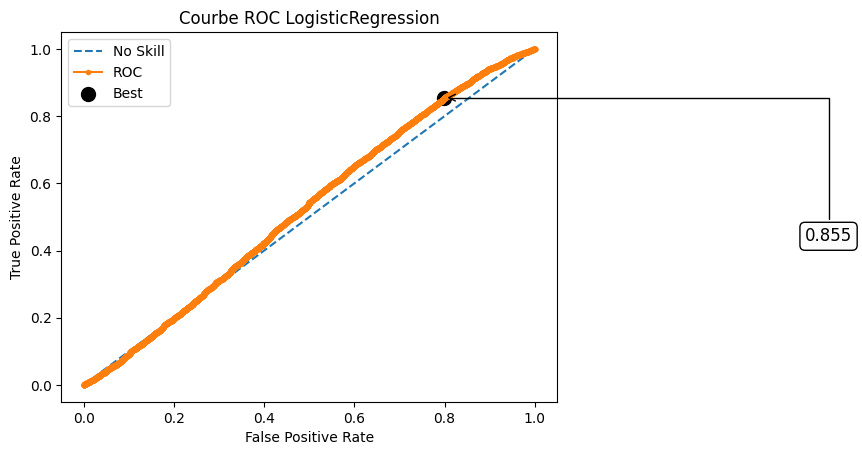

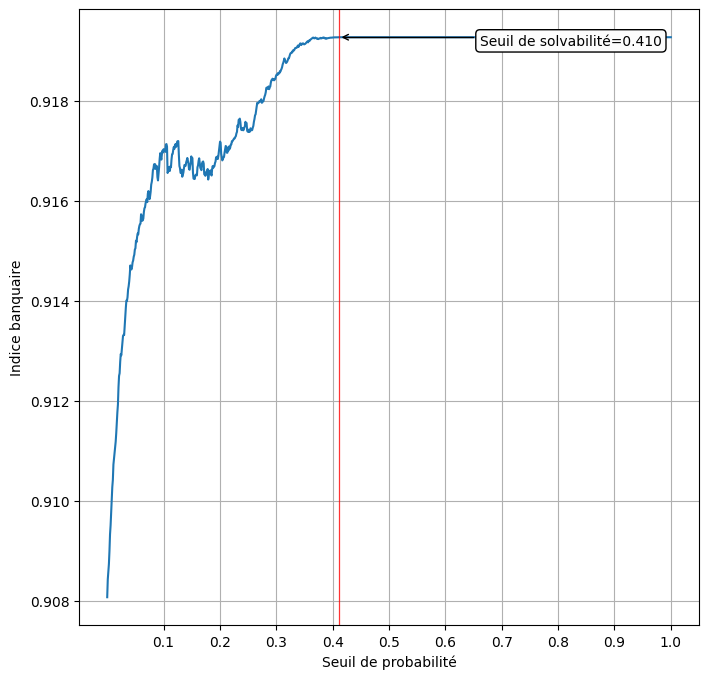

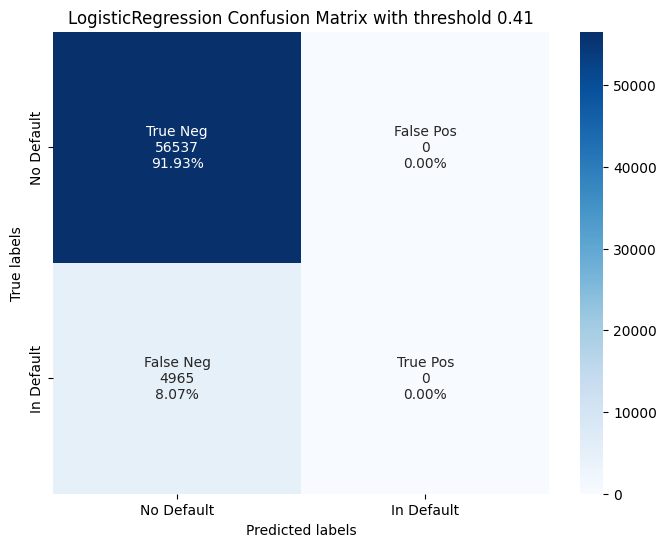

LogisticRegression Classification Report
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56537
           1       0.00      0.00      0.00      4965

    accuracy                           0.92     61502
   macro avg       0.46      0.50      0.48     61502
weighted avg       0.85      0.92      0.88     61502



In [55]:
seuil_LR = display_res(LogisticRegression,best_params_LogisticRegression,'LogisticRegression')

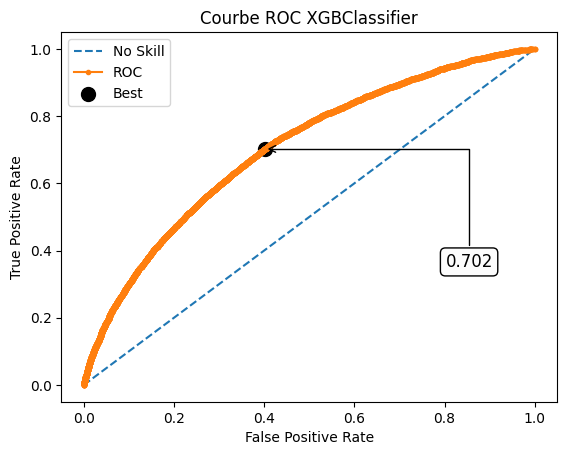

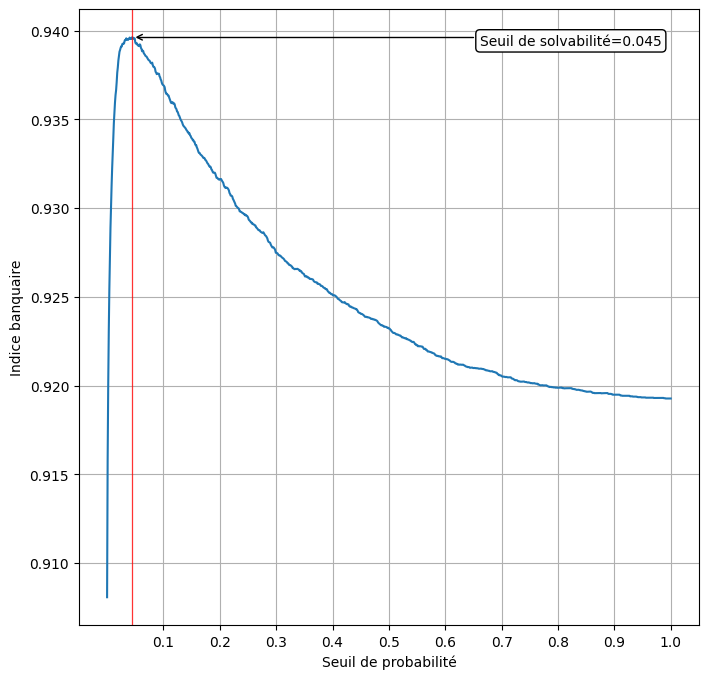

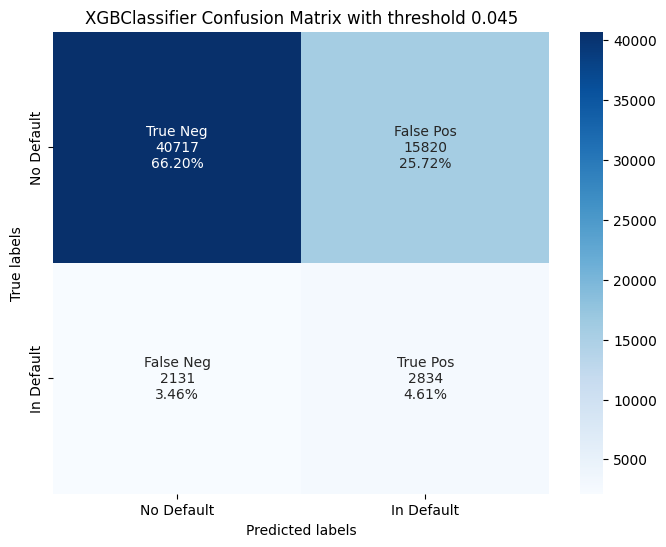

XGBClassifier Classification Report
              precision    recall  f1-score   support

           0       0.95      0.72      0.82     56537
           1       0.15      0.57      0.24      4965

    accuracy                           0.71     61502
   macro avg       0.55      0.65      0.53     61502
weighted avg       0.89      0.71      0.77     61502



In [56]:
seuil_XGBC = display_res(xgb.XGBClassifier,best_params_XGBClassifier,'XGBClassifier')

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 19860, number of negative: 226147
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11681
[LightGBM] [Info] Number of data points in the train set: 246007, number of used features: 127
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432478
[LightGBM] [Info] Start training from score -2.432478
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


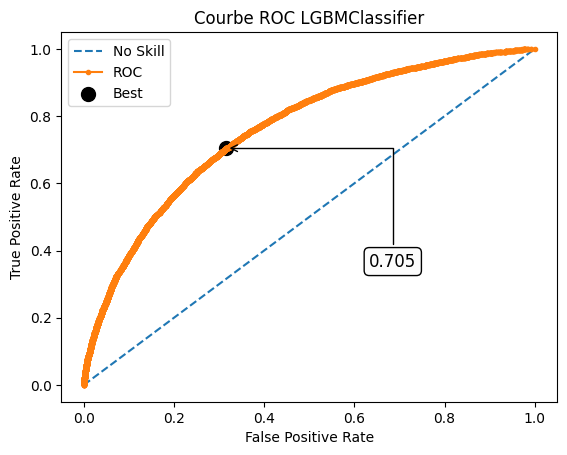

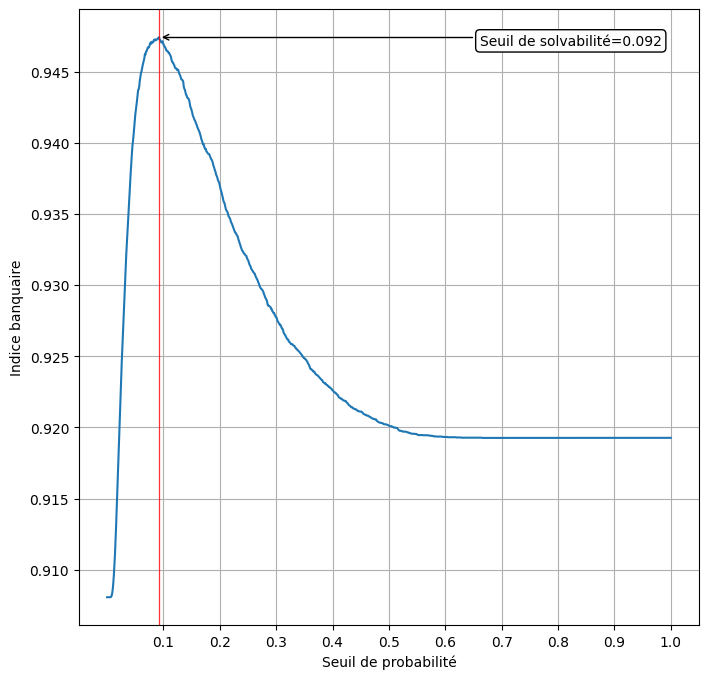

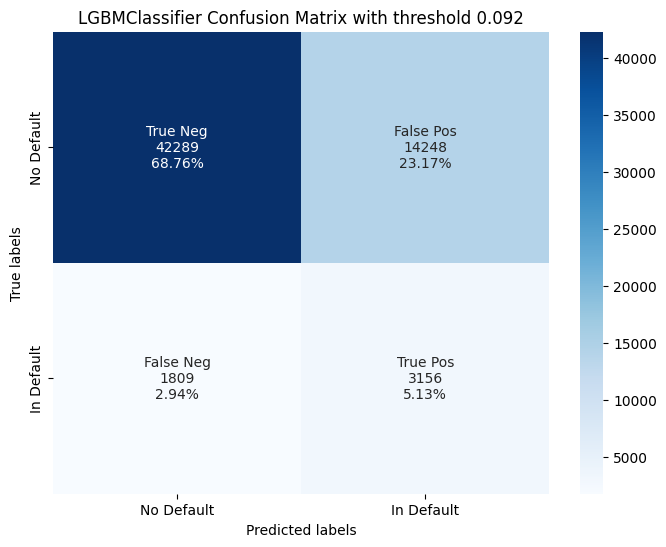

LGBMClassifier Classification Report
              precision    recall  f1-score   support

           0       0.96      0.75      0.84     56537
           1       0.18      0.64      0.28      4965

    accuracy                           0.74     61502
   macro avg       0.57      0.69      0.56     61502
weighted avg       0.90      0.74      0.80     61502



In [57]:
seuil_LGBM = display_res(lgm.LGBMClassifier,best_params_LGBMClassifier,'LGBMClassifier')

Les résultats nous indiquaient LGBMClassifier comme le modèle le plus pertinent, et en effet, ces graphiques nous le confirment. Surtout la matrice de confusion qui nous montre qu'il y a seulement 2.94% de faux négatifs et 23.17% de faux positifs, qui sont les résultats les plus bas des 3 modèles.

# Sauvegarde du meilleur modèle

In [120]:
X_train1 = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
model_opti = lgm.LGBMClassifier(**best_params_LGBMClassifier)
model_opti.fit(X_train1, y_train)
y_probas = model_opti.predict_proba(X_test.values)[:,1]

#Exporter le modèle
filename = 'BEST_MODEL.sav'
pickle.dump(model_opti, open(filename, 'wb'))

#Exporter le seuil
f = open("seuil.txt","w")
f.write(str(seuil_LGBM))
f.close()

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 19860, number of negative: 226147
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11681
[LightGBM] [Info] Number of data points in the train set: 246007, number of used features: 127
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432478
[LightGBM] [Info] Start training from score -2.432478
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


# Feature Importance

## Globale

In [33]:
explainer = shap.Explainer(model_opti)
shap_values = explainer(X_test)

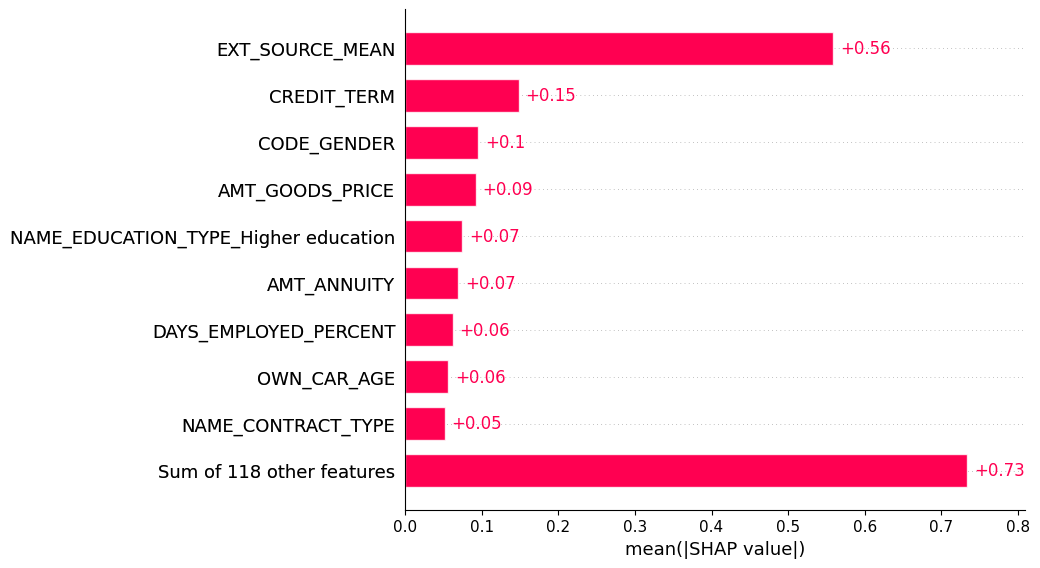

In [59]:
shap.plots.bar(shap_values,max_display=10)

La feature qui a le plus gros poids lors de l'entrainement est "EXT_SOURCE_MEAN" qui représente un score bancaire de source externe à nos données, il est donc logiaue qu'un score bancaire est un poids important dans une décision d'allocation d'un crédit. On voit ensuite différentes features qui sont tout aussi logique, comme le nombre de jours où la personne à un travail sur l'année, le type de contrat de travail de la personne, si la personne a une voiture ou non etc...

## Locale

In [54]:
idx = 21
print("Prediction : ", 
      "Rejetée" if model_opti.predict_proba(X_test.values[idx].reshape(1,-1))[:,1] > seuil_LGBM else 'Acceptée')
print("Actual :     ", "Rejetée" if y_test.iloc[idx] == 1 else 'Acceptée')
print("IDX :        ", idx)

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
Prediction :  Rejetée
Actual :      Rejetée
IDX :         21


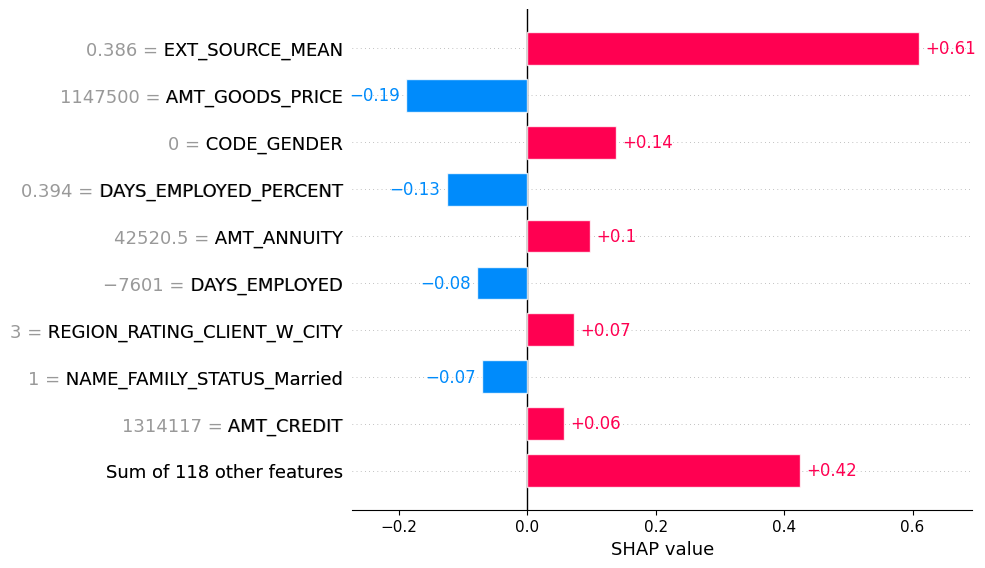

In [55]:
shap.plots.bar(shap_values[idx],max_display=10)

Sur un exemple de rejet, on voit que le score bancaire externe représente la raison principale du rejet, les autres features n'étant pas assez en la faveur de la personne pour compenser

In [52]:
idx = 20
print("Prediction : ", 
      "Rejetée" if model_opti.predict_proba(X_test.values[idx].reshape(1,-1))[:,1] > seuil_LGBM else 'Acceptée')
print("Actual :     ", "Rejetée" if y_test.iloc[idx] == 1 else 'Acceptée')
print("IDX :        ", idx)

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
Prediction :  Acceptée
Actual :      Acceptée
IDX :         20


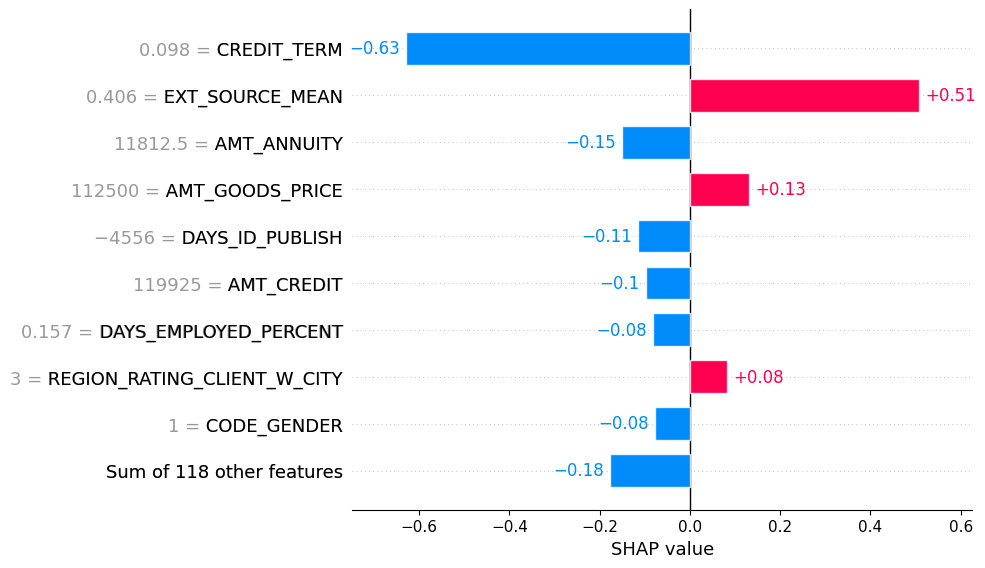

In [53]:
shap.plots.bar(shap_values[idx],max_display=10)

Sur un exemple d'acceptetion, on voit que le temps restant sur le crédit en cours est la raison principale de la décision, même si le score bancaire externe n'était pas en la faveur de la personne, les autres features étant globalement plutôt en sa faveur.

In [ ]:
!mlflow ui --port 8080